In [1]:
pip install duckduckgo_search

  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached importlib_metadata-6.0.0-py3-none-any.whl (21 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 2.6 MB/s eta 0:00:00a 0:00:01
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 KB 5.8 MB/s eta 0:00:00
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
You should consider upgrading via the '/Users/dikshapaliwal/.pyenv/versions/3.7.16/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip list

Package                  Version
------------------------ ----------
aiohttp                  3.8.4
aiosignal                1.3.1
anyio                    3.6.2
appnope                  0.1.3
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
asttokens                2.2.1
async-timeout            4.0.2
attrs                    22.2.0
backcall                 0.2.0
beautifulsoup4           4.11.2
bleach                   6.0.0
blis                     0.7.9
catalogue                2.0.8
certifi                  2022.12.7
cffi                     1.15.1
charset-normalizer       3.1.0
click                    8.1.3
comm                     0.1.2
confection               0.0.4
contourpy                1.0.7
cycler                   0.11.0
cymem                    2.0.7
datasets                 2.10.1
debugpy                  1.6.6
decorator                5.1.1
defusedxml               0.7.1
dill                     0.3.6
duckduckgo-search    

In [5]:
! [ -e /content ] && pip install -Uqq fastbook


In [1]:
import fastbook
# fastbook.setup_book()

In [2]:
from fastbook import *
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
import PIL

In [3]:

def search_images(term,max_images = 30):

  """term: object we are searching images for
      max_images : max no. of images we need"""

  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results=max_images)).itemgot('image')



Searching for 'weapon photos'


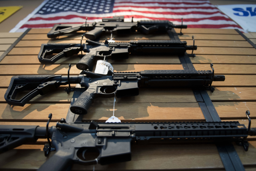

In [4]:
#Fetching an image and showing it.

urls = search_images('weapon photos', max_images=1)
# urls[0]
dest = 'weapon22.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'human holding weapon photos'


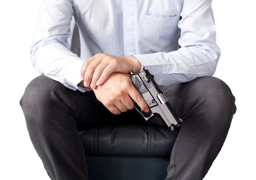

In [5]:
#fetching for different search 


download_url(search_images('human holding weapon photos')[3], 'human_weapon1.jpg', show_progress=False)
im = Image.open('human_weapon1.jpg')
im.to_thumb(256,256)


In [7]:
searches = 'weapons','human holding weapon photos'
path = Path('holding_weapon_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} indoor photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} outdoor photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'weapons photo'
Searching for 'weapons indoor photo'
Searching for 'weapons outdoor photo'
Searching for 'human holding weapon photos photo'
Searching for 'human holding weapon photos indoor photo'
Searching for 'human holding weapon photos outdoor photo'


Training Model

In [8]:
#Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

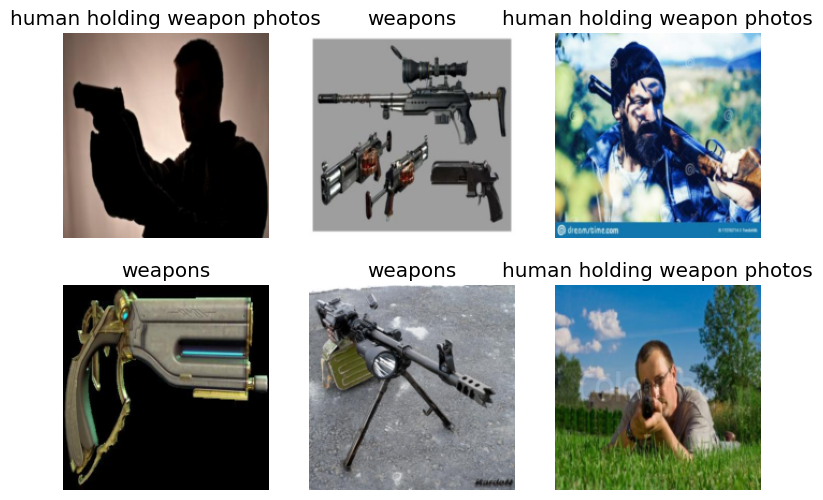

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/dikshapaliwal/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dikshapaliwal/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/dikshapaliwal/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.910949,0.254078,0.121212,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.439721,0.070855,0.000000,00:03
1,0.298147,0.057472,0.030303,00:01
2,0.216699,0.078146,0.030303,00:01


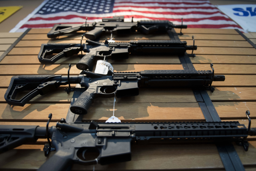

In [14]:
image = Image.open('weapon22.jpg')
# Create a PIL Image object from the opened image
pil_image = image.copy()
pil_image.to_thumb(256,256)

# Close the image file
# image.close()


In [15]:
is_holding_weapon,_,probs = learn.predict(pil_image)
print(f"This is a: {is_holding_weapon} image.")
print(f"Probability of human holding a weapon': {probs[0]:.4f}")

This is a: weapons image.
Probability of human holding a weapon': 0.0006
